In [1]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, BinaryCrossEntropyLoss, QuantumTrainer, SPSAOptimizer, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("ja_ginza")

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# データセット読み込み
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            # labels.append([[0, t],[0, 1-t]]) # 2×2行列の形で格納するならこっち
            labels.append([1-t, t]) # 1×2行列の形
            sentences.append(line[1:].strip())
            
    return np.array(labels), sentences

train_labels, train_sentences = read_data('C:/Users/neoia//研究/data/mc_train_data_jp.txt')
dev_labels, dev_sentences = read_data('C:/Users/neoia//研究/data/mc_dev_data_jp.txt')
test_labels, test_sentences = read_data('C:/Users/neoia//研究/data/mc_test_data_jp.txt')

In [3]:
train_sentences

['熟練した男はソースを準備します。',
 '熟練した男は夕食を焼きます。',
 '女性はおいしい食事を作っています。',
 '男は食事を準備します。',
 '熟練した女性がプログラムをデバッグします。',
 '女性はおいしい食事を準備します。',
 '人はプログラムを実行します。',
 '人は有用なアプリケーションを実行します。',
 '女性はソースを準備します。',
 '女性は夕食を準備します。',
 '熟練した人は食事を準備します。',
 '熟練した人は夕食を焼きます。',
 '熟練した女性は食事を焼きます。',
 '女性は有用なアプリケーションを実行します。',
 '男はおいしい食事を焼きます。',
 '人はおいしい食事を準備します。',
 '女性はアプリケーションを実行します。',
 '男はソフトウェアを準備します。',
 '男はおいしい夕食を焼きます。',
 '人は有用なプログラムを準備します。',
 '男は有用なアプリケーションをデバッグします。',
 '人は有用なアプリケーションをデバッグします。',
 '女性はプログラムを準備します。',
 '男性は有用なアプリケーションを準備します。',
 '熟練した男が夕食を作る。',
 '男性は有用なソフトウェアをデバッグします。',
 '人は夕食を作っています。',
 '熟練した女性は食事を準備します。',
 '男は申請を準備します。',
 '人は便利なソフトウェアをデバッグします。',
 '人は申請を実行します。',
 '熟練した女性はソースを焼きます。',
 '熟練した男は食事を焼きます。',
 '女性は食事を作っています。',
 '女性は夕食を焼きます。',
 '女性はプログラムを実行します。',
 '熟練した男はプログラムを準備します。',
 '熟練した男が食事を作る。',
 '女性はソフトウェアを実行します。',
 '熟練した男はソフトウェアをデバッグします。',
 '男は夕食を作っています。',
 '女性はおいしい夕食を作っています。',
 '女性は夕食を作っています。',
 '男はおいしいソースを焼きます。',
 '男は夕食を準備します。',
 '熟練した人はソースを調理します。',
 '熟練した男はソフトウェアを準備します。',
 '人はソフトウェアを準備します。',
 '人はソフトウェアを

In [4]:
# 型の割り当て
def assign_types(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]
    # 依存関係をまとめる
    # dependencies = [(token.text, token.head.text) for token in doc if token.text != "."]
    dependencies = []
    
    for token in doc:
        if token.dep_ == 'ROOT':
            pregroup_types[token.text] = s
            dependencies.append((token.text, token.head.text))
        elif token.pos_ in ['NOUN','PRON']:
            pregroup_types[token.text] = n
            if token.head.dep_ == 'ROOT':
                dependencies.append((token.text, token.head.text))
    print(dependencies)
    # 依存関係による型の割り当て（ペアと語順）
    
    for dep in dependencies:
        idx1 = tokens.index(dep[0])
        idx2 = tokens.index(dep[1])
        if idx1 < idx2:
            pregroup_types[token.head.text] = n.r @ pregroup_types[token.head.text]
        elif idx1 > idx2:
            pregroup_types[token.head.text] = pregroup_types[token.head.text] @ n.l
        else:
            pass

    return pregroup_types

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

# 日本語フォントを設定
font_path = "C:\\Windows\\Fonts\\meiryo.ttc" 
jp_font = fm.FontProperties(fname=font_path) 
# matplotlibにフォントを設定
rcParams['font.family'] = jp_font.get_name()

# creating diagram
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # making cups
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

[('男', '準備'), ('ソース', '準備'), ('準備', '準備')]
[('男', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('女性', '作っ'), ('食事', '作っ'), ('作っ', '作っ')]
[('男', '準備'), ('食事', '準備'), ('準備', '準備')]
[('女性', 'デバッグ'), ('プログラム', 'デバッグ'), ('デバッグ', 'デバッグ')]
[('女性', '準備'), ('食事', '準備'), ('準備', '準備')]
[('人', '実行'), ('プログラム', '実行'), ('実行', '実行')]
[('人', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('女性', '準備'), ('ソース', '準備'), ('準備', '準備')]
[('女性', '準備'), ('夕食', '準備'), ('準備', '準備')]
[('人', '準備'), ('食事', '準備'), ('準備', '準備')]
[('人', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('女性', '焼き'), ('食事', '焼き'), ('焼き', '焼き')]
[('女性', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('男', '焼き'), ('食事', '焼き'), ('焼き', '焼き')]
[('人', '準備'), ('食事', '準備'), ('準備', '準備')]
[('女性', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('男', '準備'), ('ソフトウェア', '準備'), ('準備', '準備')]
[('男', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('人', '準備'), ('プログラム', '準備'), ('準備', '準備')]
[('男', 'デバッグ'), ('アプリケーション', 'デバッグ'), ('デバッグ', 'デバッグ')]
[('人', 'デバッグ'), ('アプリケーション', 'デバッグ'), ('デバッグ', 'デバッグ')]

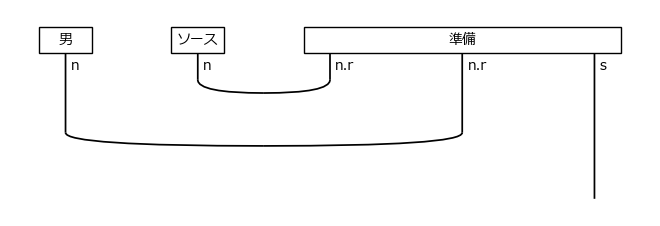

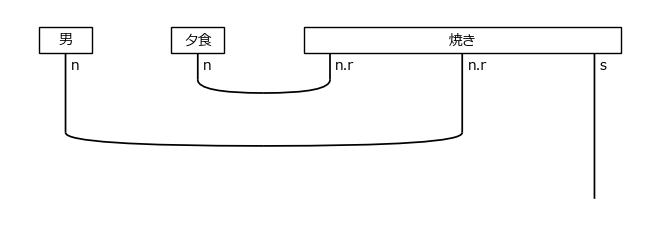

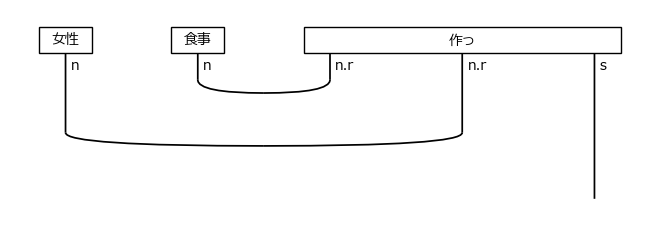

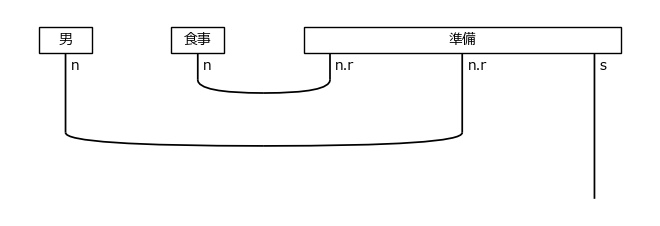

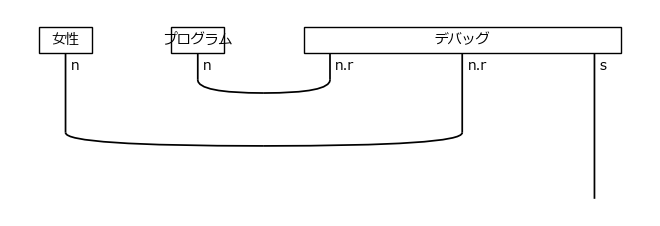

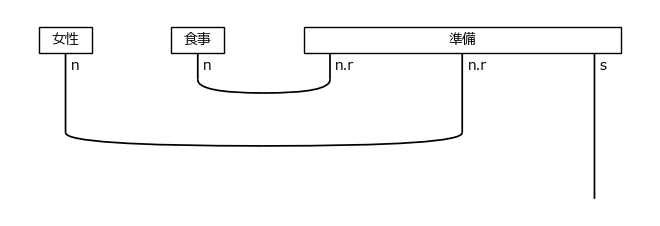

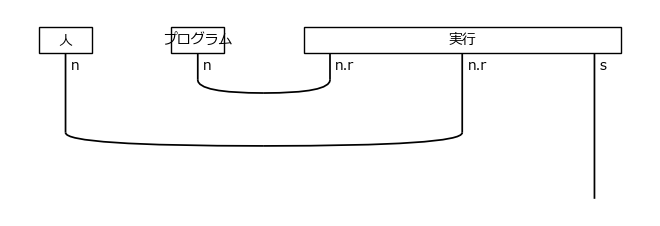

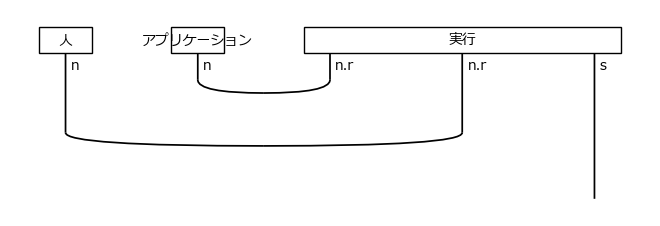

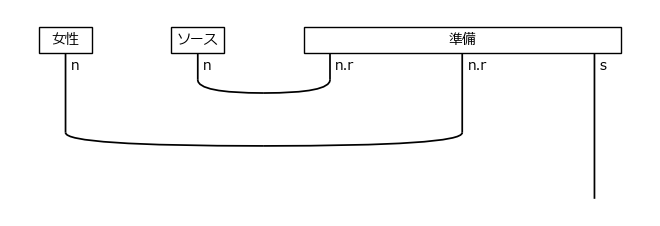

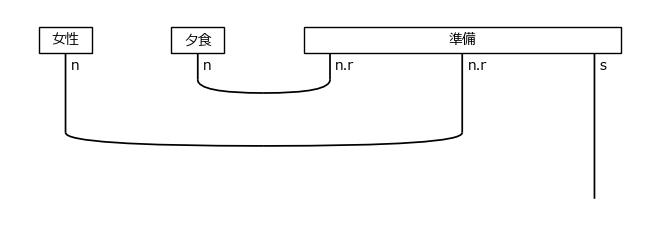

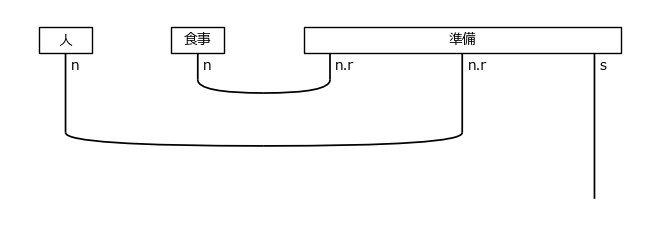

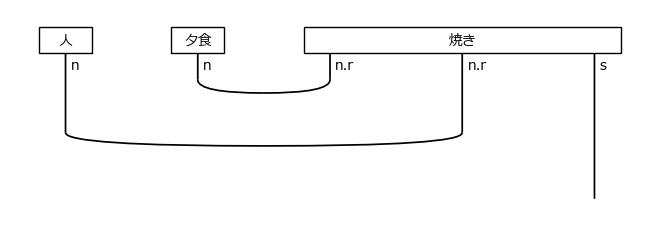

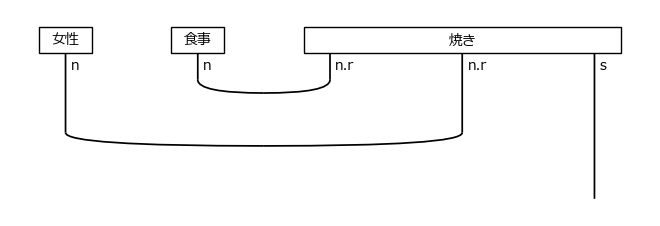

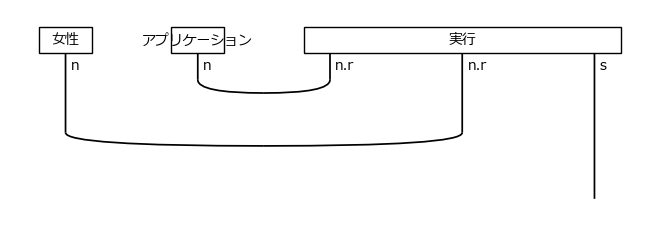

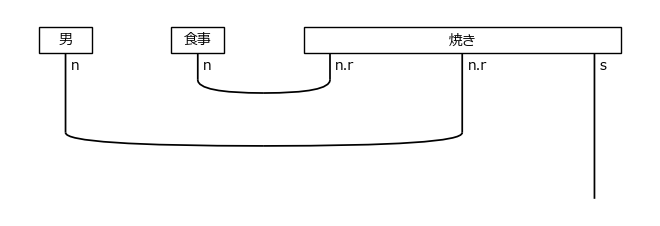

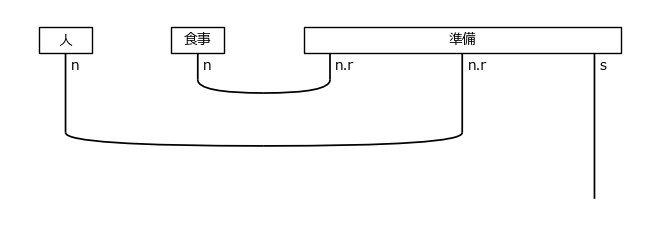

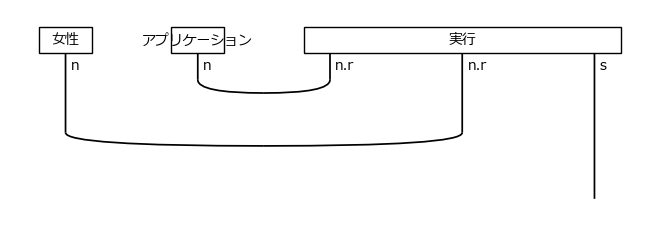

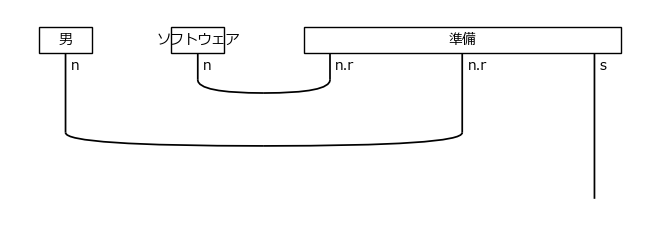

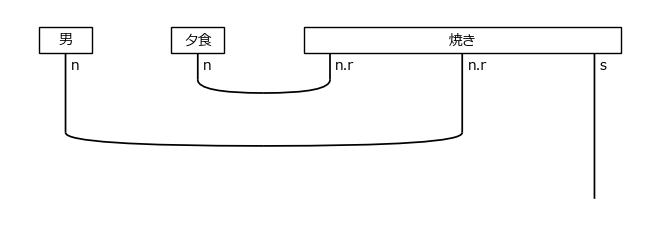

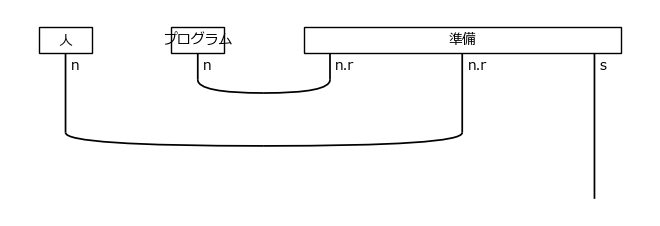

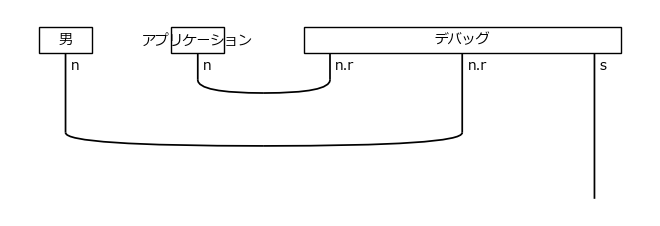

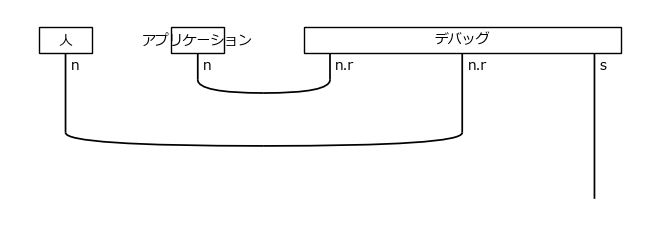

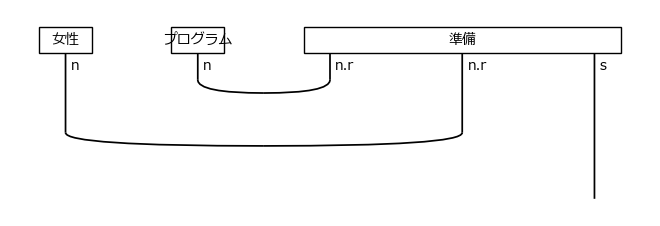

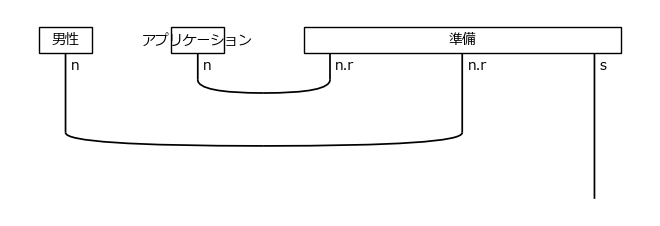

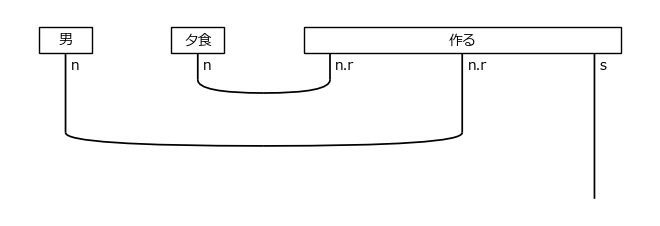

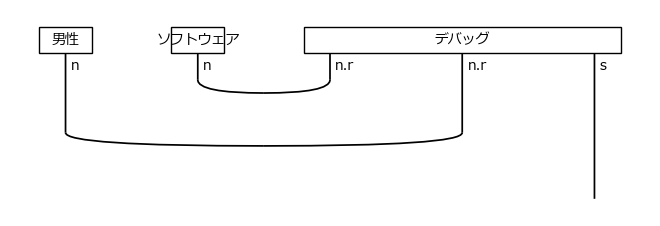

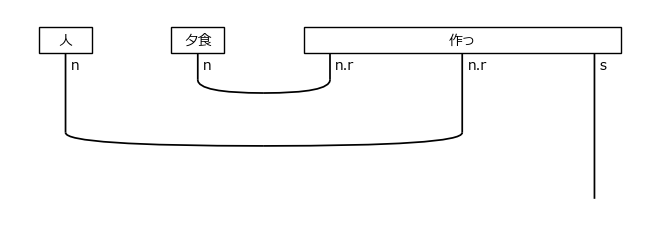

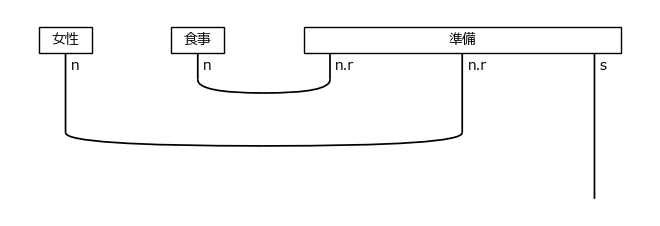

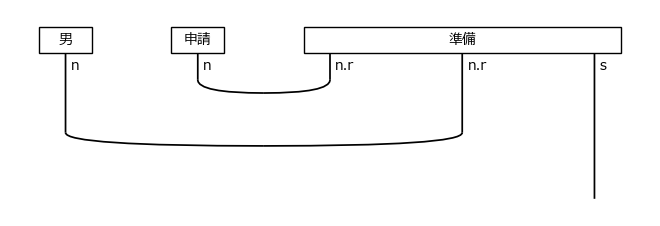

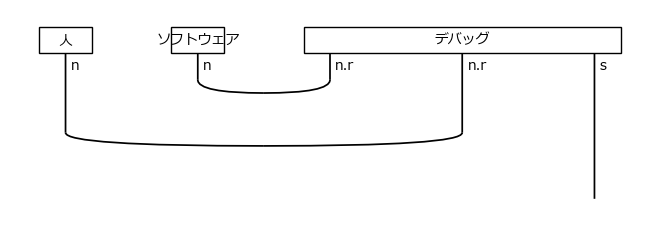

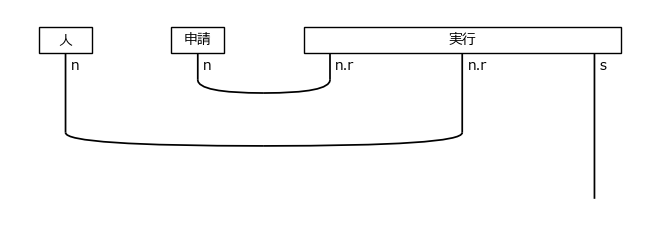

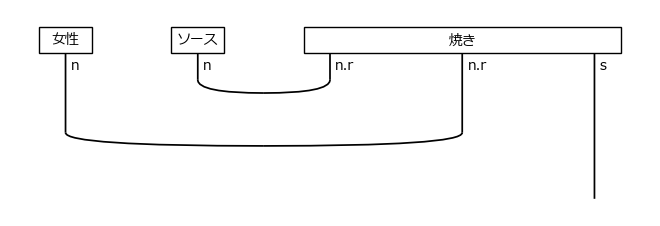

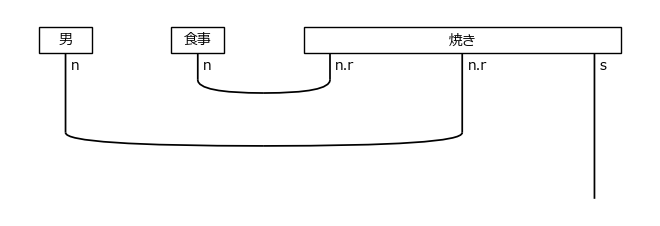

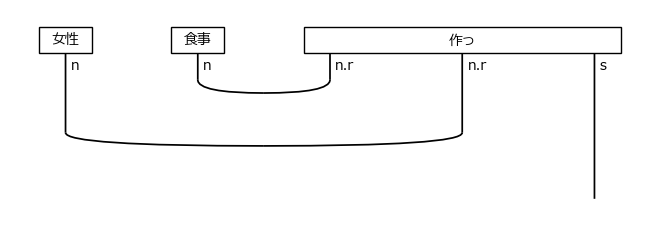

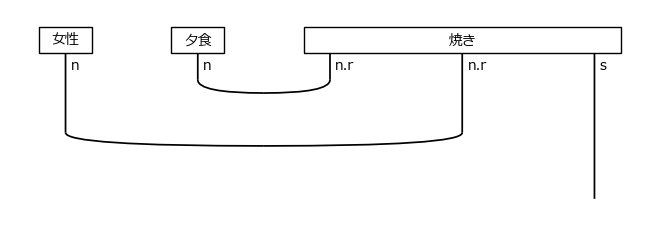

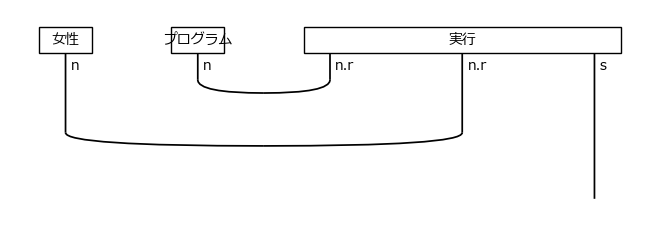

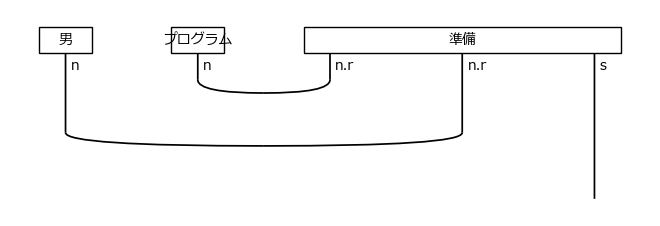

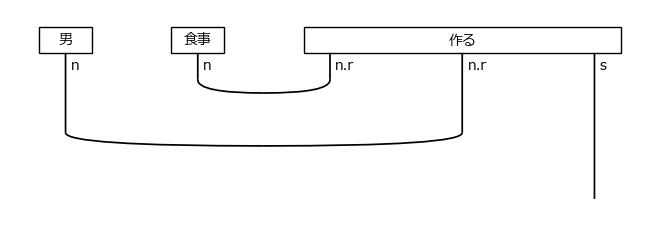

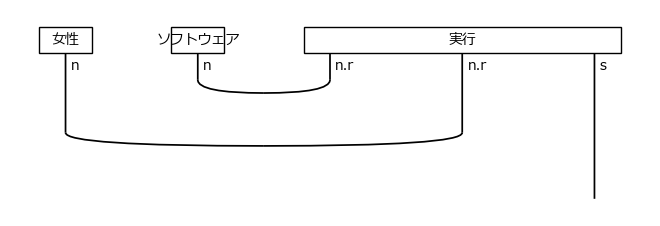

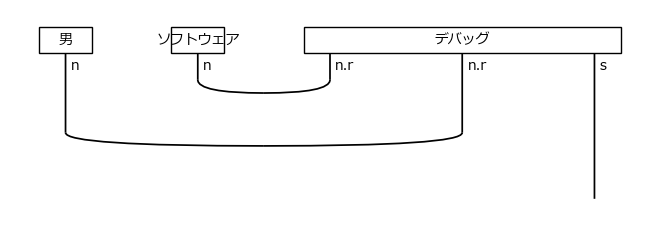

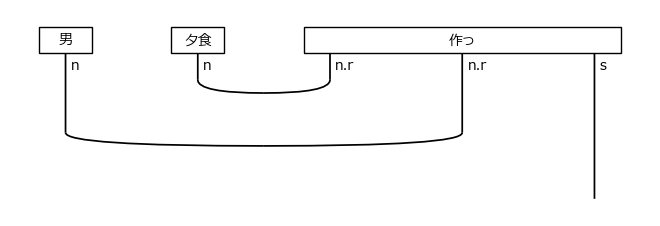

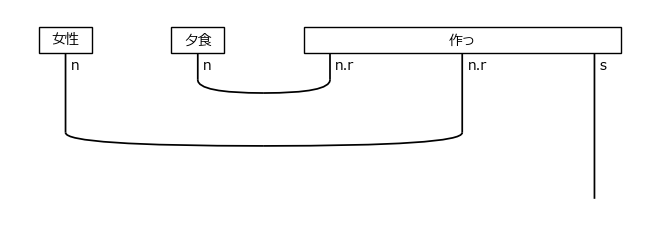

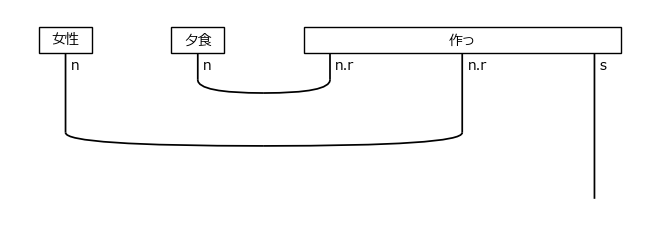

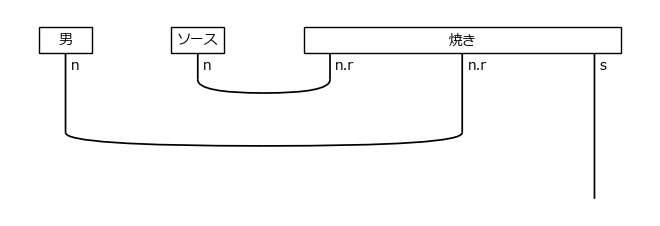

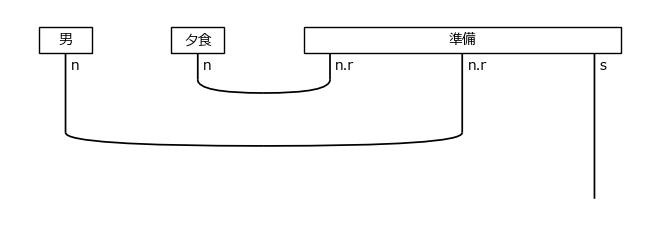

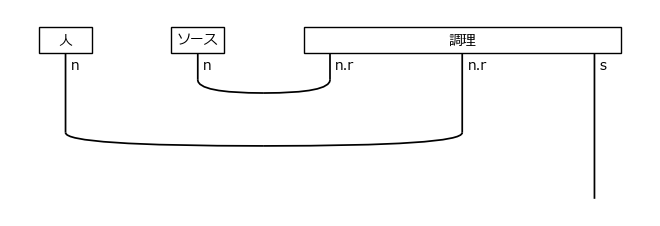

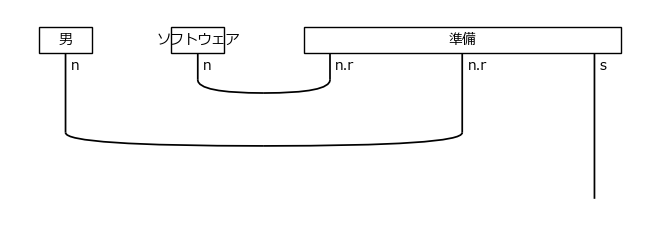

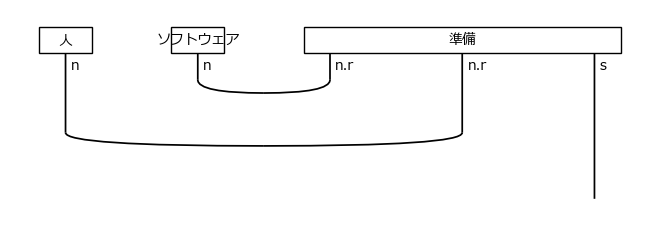

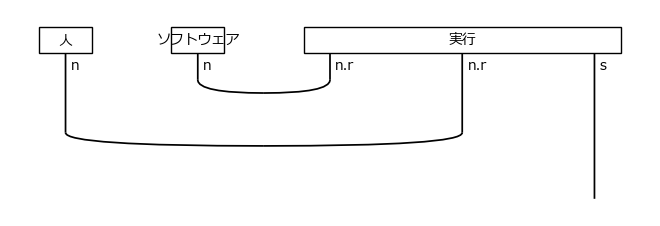

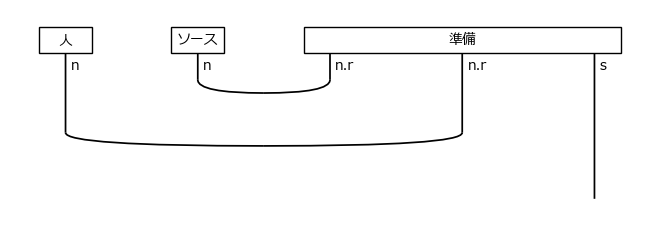

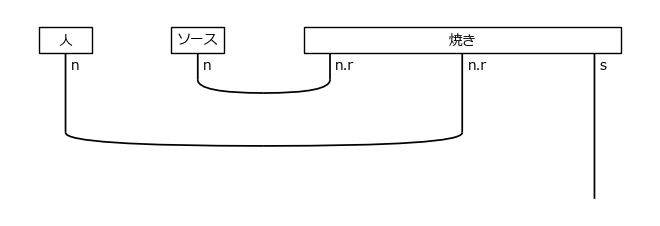

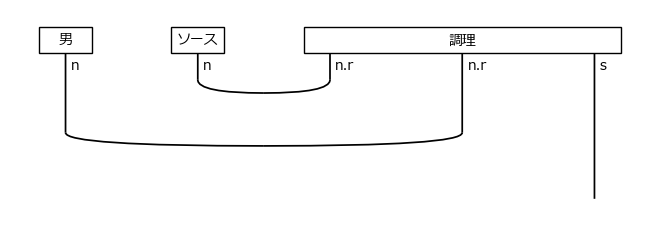

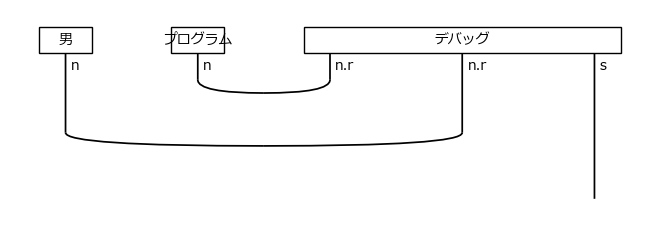

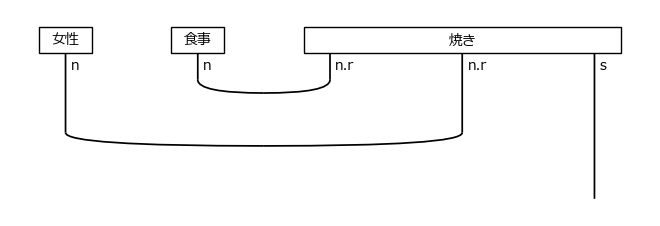

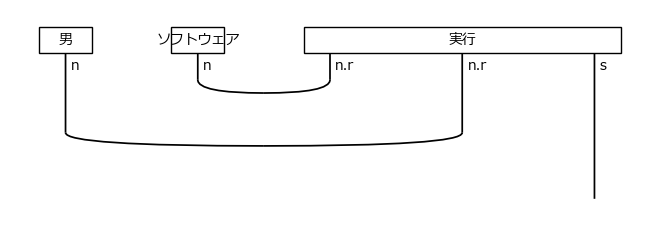

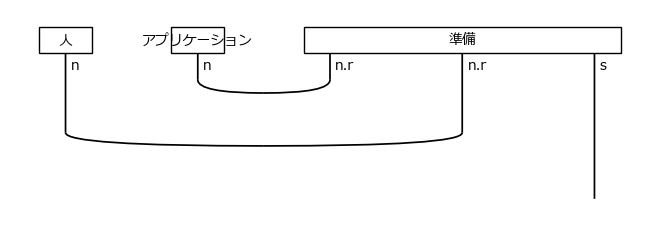

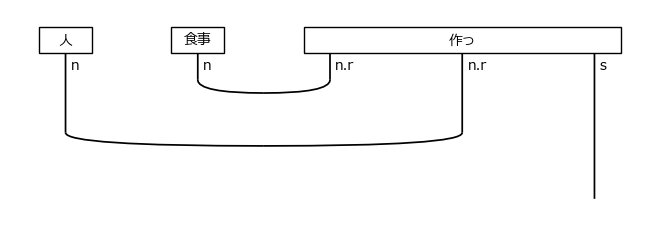

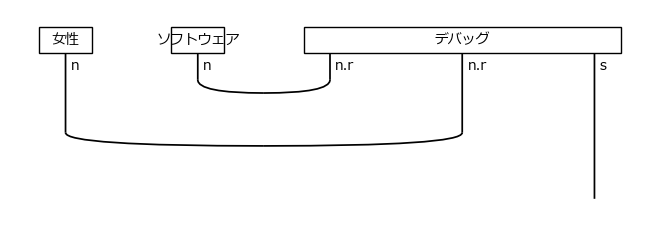

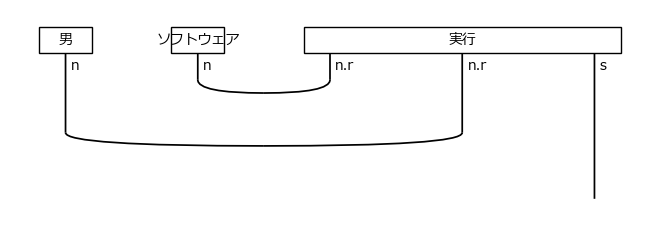

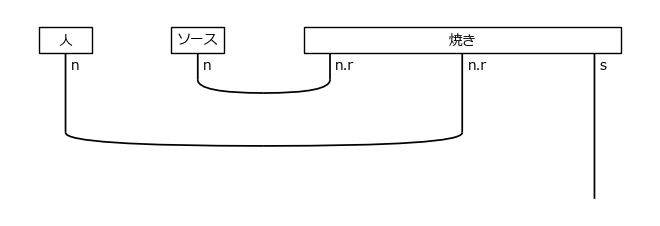

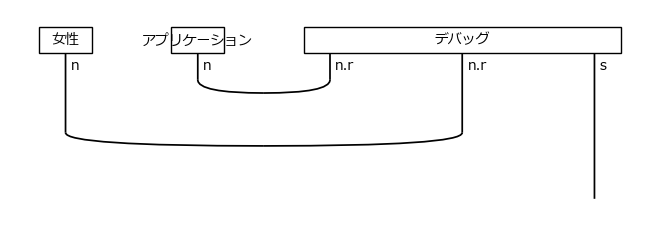

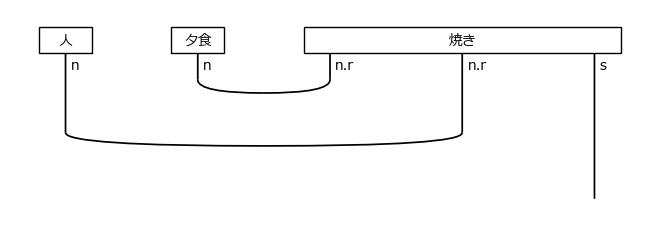

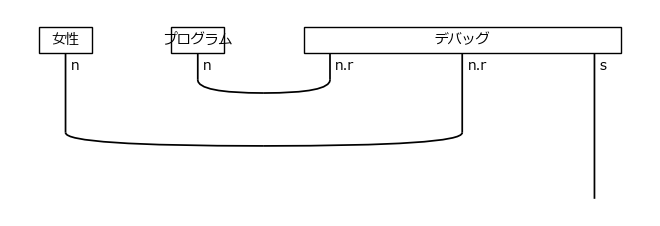

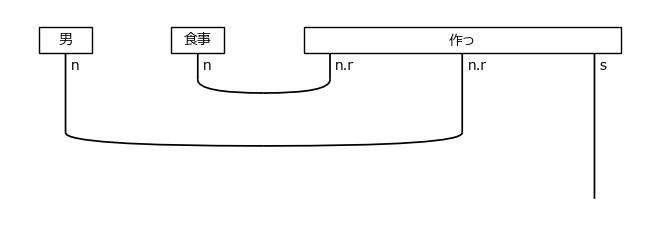

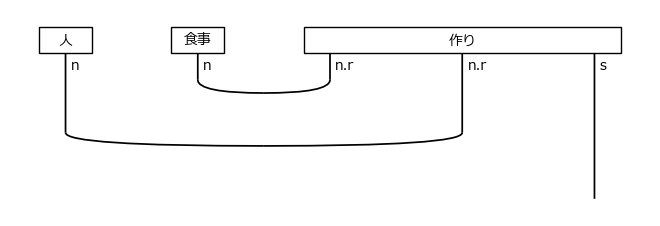

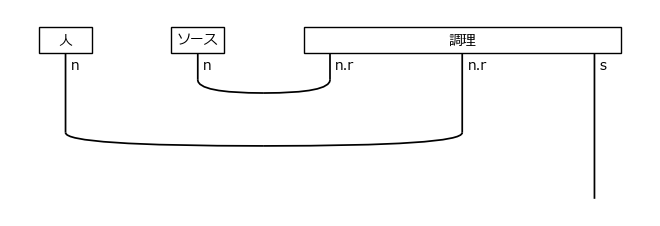

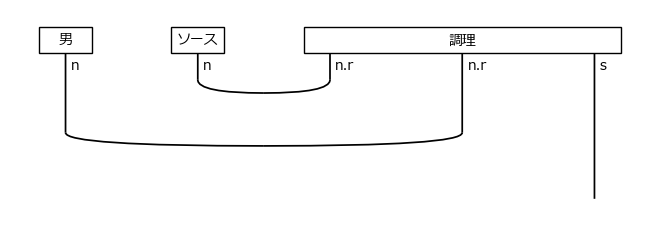

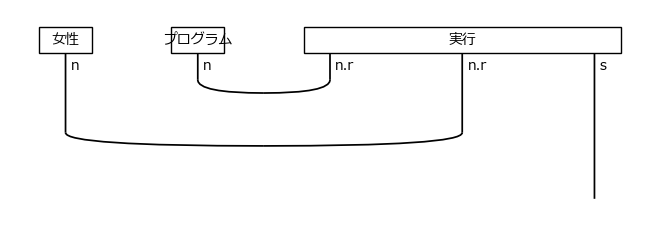

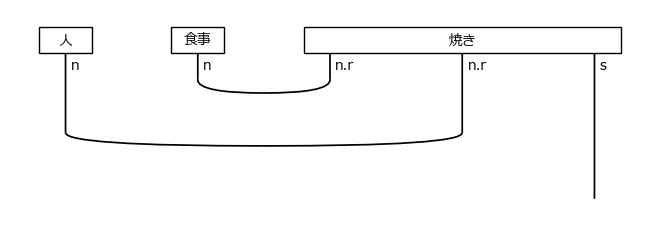

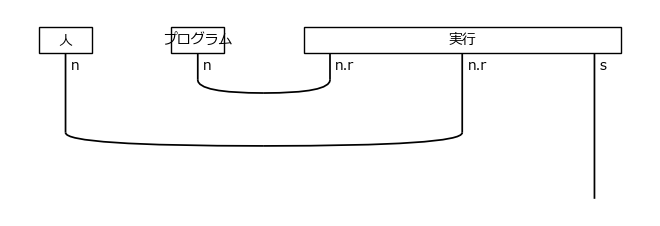

In [6]:
train_diagrams = []
dev_diagrams = []
test_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    train_diagrams.append(create_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    dev_diagrams.append(create_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    test_diagrams.append(create_diagram(sentence))

# check diagrams
for d in range(len(train_sentences)):
    draw(train_diagrams[d])

In [7]:
def rotate_type(sentence: str, target_word: str, k: int = 1):
    
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)
    target_types = []
    rotated = []
    rotated_type = Ty()
    
    org_type = pregroup_types[target_word]
    target_types = list(org_type)
    
    def swap_with_prev(d, key):
        items = list(d.items())
        keys = [k for k, _ in items]
        i = keys.index(key)
        if i == 0:
            return d  # 先頭なら入れ替え不可
        items[i - 1], items[i] = items[i], items[i - 1]
        return dict(items)
    
    def swap_with_next(d, key):
        items = list(d.items())
        keys = [k for k, _ in items]
        i = keys.index(key)
        if i + 1 >= len(items):
            return d  # 最後尾なら無理
        items[i], items[i + 1] = items[i + 1], items[i]
        return dict(items)
    
    k = k % len(target_types)  # リスト長で割った余りだけ回す
    rotated = target_types[k:] + target_types[:k]
    
    rotated_types = target_types[:k]
    slided_types = target_types[k:]
    if k <= target_types.index(s):
        for i in range(len(rotated_types)):
            # 右随伴なら
            if  rotated_types[i] == n.r:
                pregroup_types = swap_with_prev(pregroup_types,target_word)
                rotated_types[i] = n.l 
                
            else:
                pass

    else:
        for i in range(len(slided_types)):       
            if  slided_types[i] == n.r:
                pregroup_types = swap_with_next(pregroup_types,target_word)
                slided_types[i] = n.l 
            else:
                pass
    rotated = slided_types + rotated_types
    
    for i in rotated:
        rotated_type @= i
    rotated_type
    
    pregroup_types[target_word] = rotated_type
    
    return pregroup_types

In [8]:
# diagram作成
def create_rotated_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = rotate_type(doc, target_word)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

In [9]:
train_rot_types = []
dev_rot_types = []
test_rot_types = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    train_rot_types.append(rotate_type(sentence, target_word))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    dev_rot_types.append(rotate_type(sentence, target_word))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    test_rot_types.append(rotate_type(sentence, target_word))
# check diagrams
for d in range(len(train_sentences)):
    print(train_rot_types[d])

[('男', '準備'), ('ソース', '準備'), ('準備', '準備')]
[('男', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('女性', '作っ'), ('食事', '作っ'), ('作っ', '作っ')]
[('男', '準備'), ('食事', '準備'), ('準備', '準備')]
[('女性', 'デバッグ'), ('プログラム', 'デバッグ'), ('デバッグ', 'デバッグ')]
[('女性', '準備'), ('食事', '準備'), ('準備', '準備')]
[('人', '実行'), ('プログラム', '実行'), ('実行', '実行')]
[('人', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('女性', '準備'), ('ソース', '準備'), ('準備', '準備')]
[('女性', '準備'), ('夕食', '準備'), ('準備', '準備')]
[('人', '準備'), ('食事', '準備'), ('準備', '準備')]
[('人', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('女性', '焼き'), ('食事', '焼き'), ('焼き', '焼き')]
[('女性', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('男', '焼き'), ('食事', '焼き'), ('焼き', '焼き')]
[('人', '準備'), ('食事', '準備'), ('準備', '準備')]
[('女性', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('男', '準備'), ('ソフトウェア', '準備'), ('準備', '準備')]
[('男', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('人', '準備'), ('プログラム', '準備'), ('準備', '準備')]
[('男', 'デバッグ'), ('アプリケーション', 'デバッグ'), ('デバッグ', 'デバッグ')]
[('人', 'デバッグ'), ('アプリケーション', 'デバッグ'), ('デバッグ', 'デバッグ')]

[('男', '準備'), ('ソース', '準備'), ('準備', '準備')]
[('男', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('女性', '作っ'), ('食事', '作っ'), ('作っ', '作っ')]
[('男', '準備'), ('食事', '準備'), ('準備', '準備')]
[('女性', 'デバッグ'), ('プログラム', 'デバッグ'), ('デバッグ', 'デバッグ')]
[('女性', '準備'), ('食事', '準備'), ('準備', '準備')]
[('人', '実行'), ('プログラム', '実行'), ('実行', '実行')]
[('人', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('女性', '準備'), ('ソース', '準備'), ('準備', '準備')]
[('女性', '準備'), ('夕食', '準備'), ('準備', '準備')]
[('人', '準備'), ('食事', '準備'), ('準備', '準備')]
[('人', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('女性', '焼き'), ('食事', '焼き'), ('焼き', '焼き')]
[('女性', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('男', '焼き'), ('食事', '焼き'), ('焼き', '焼き')]
[('人', '準備'), ('食事', '準備'), ('準備', '準備')]
[('女性', '実行'), ('アプリケーション', '実行'), ('実行', '実行')]
[('男', '準備'), ('ソフトウェア', '準備'), ('準備', '準備')]
[('男', '焼き'), ('夕食', '焼き'), ('焼き', '焼き')]
[('人', '準備'), ('プログラム', '準備'), ('準備', '準備')]
[('男', 'デバッグ'), ('アプリケーション', 'デバッグ'), ('デバッグ', 'デバッグ')]
[('人', 'デバッグ'), ('アプリケーション', 'デバッグ'), ('デバッグ', 'デバッグ')]

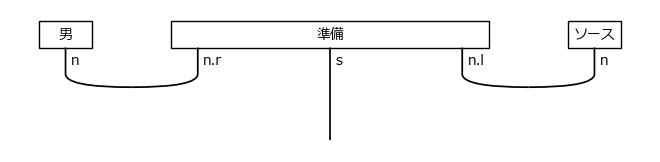

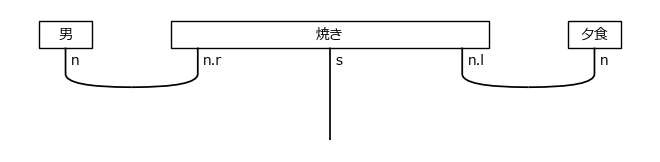

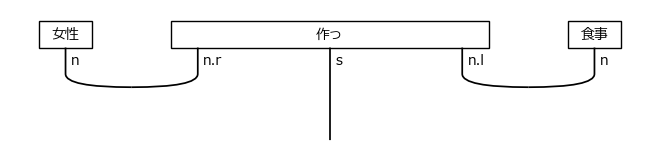

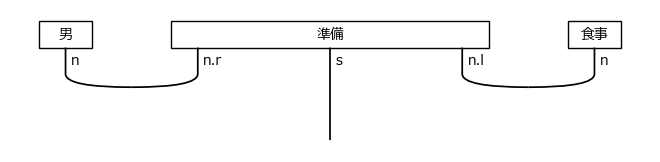

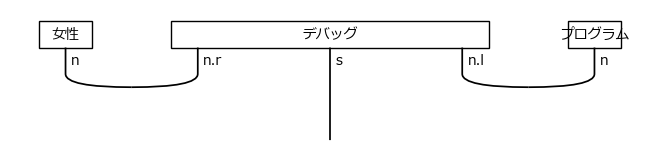

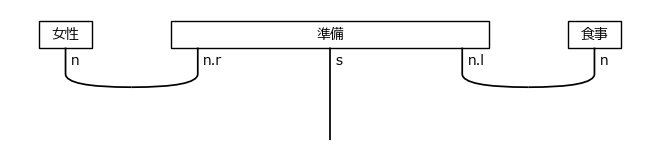

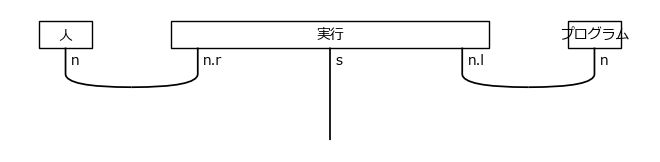

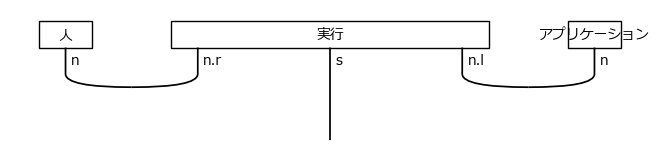

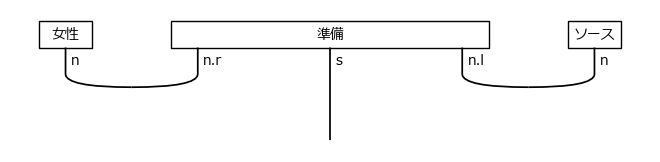

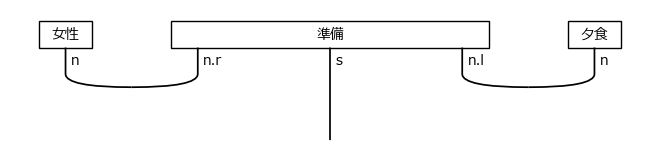

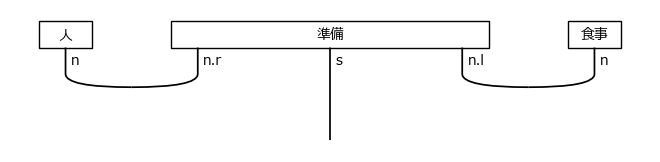

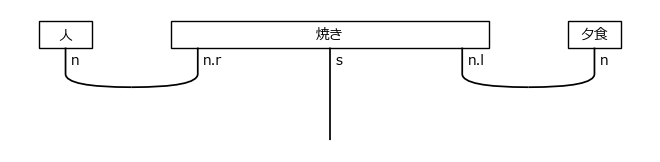

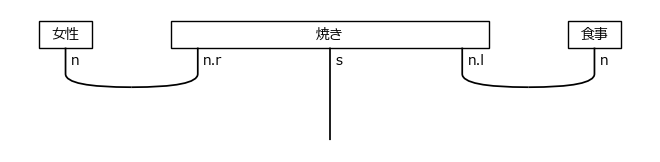

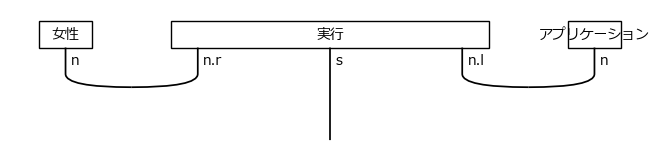

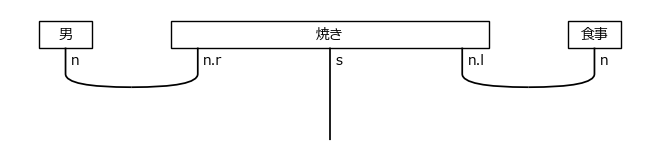

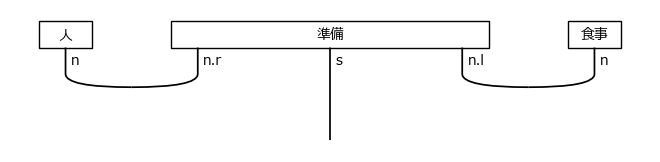

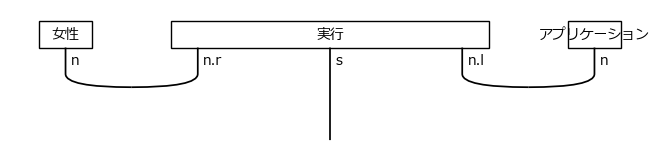

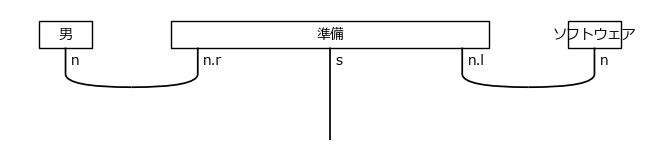

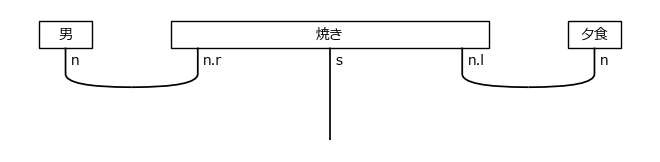

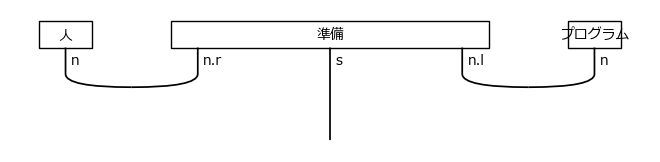

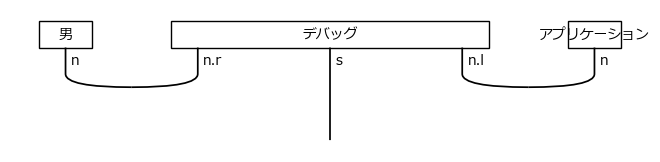

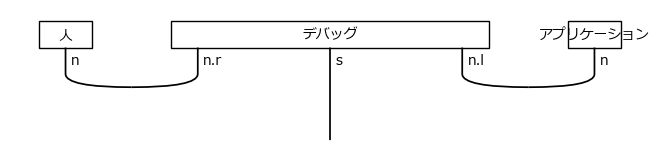

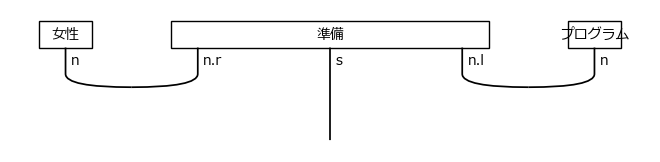

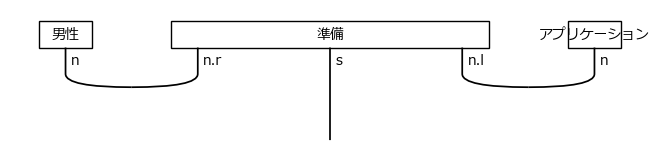

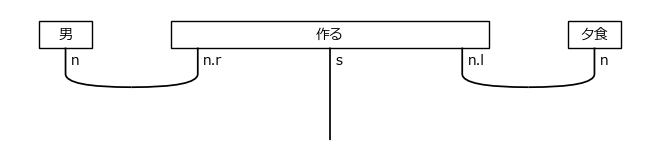

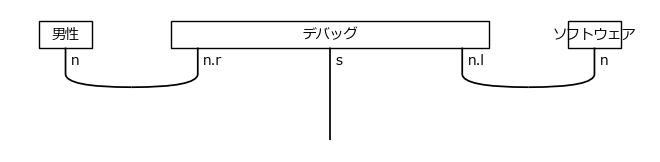

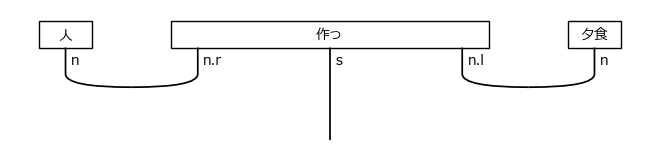

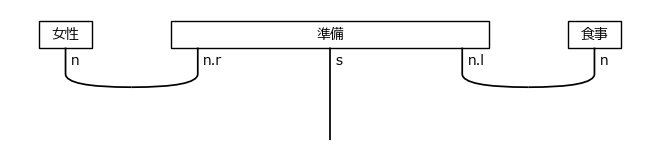

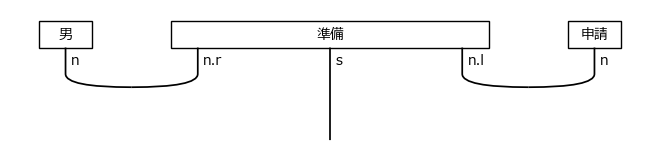

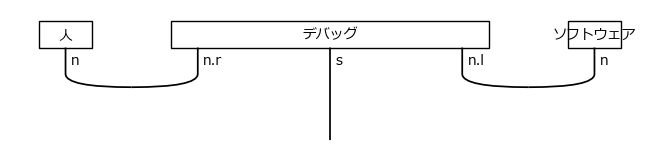

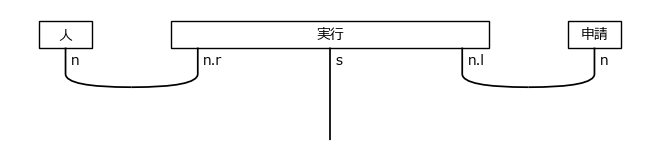

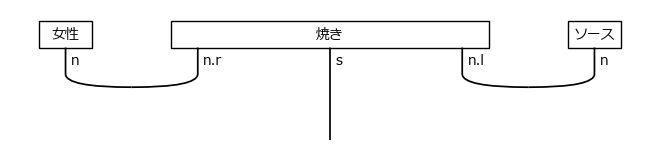

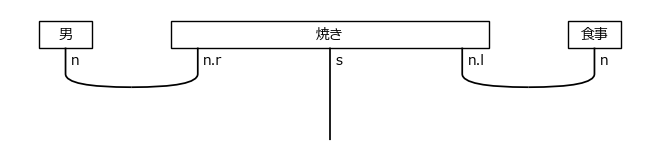

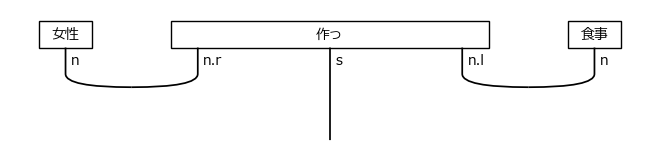

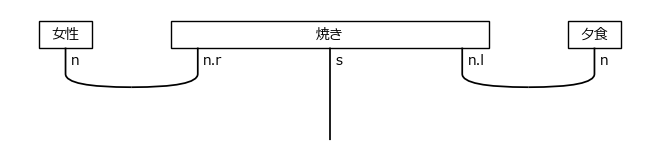

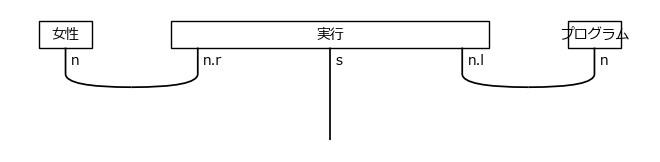

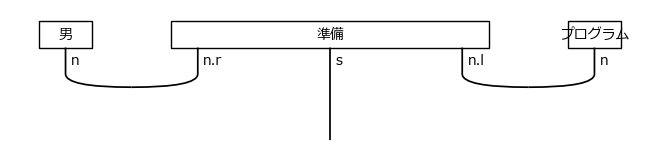

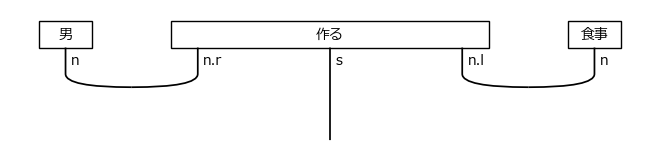

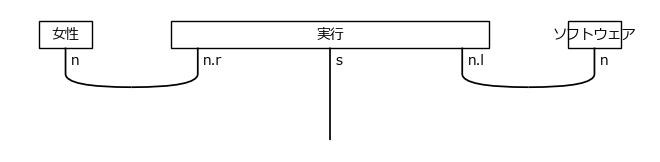

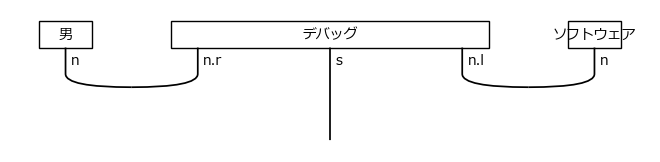

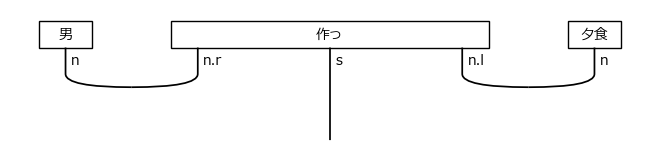

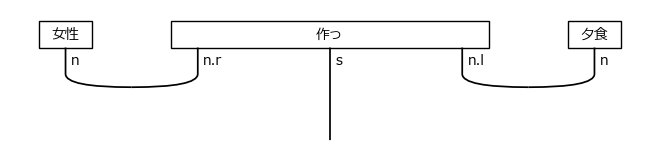

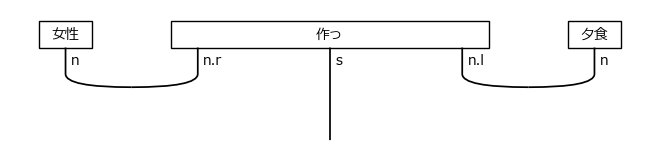

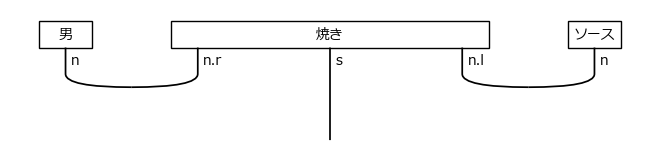

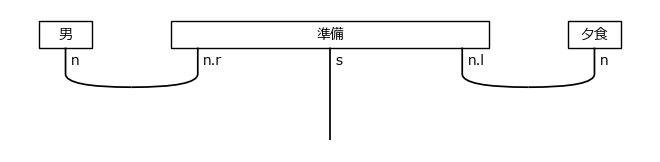

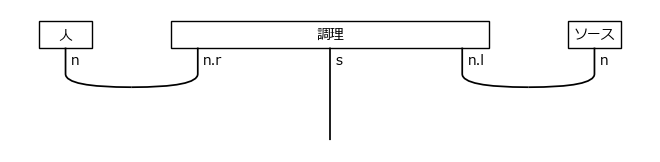

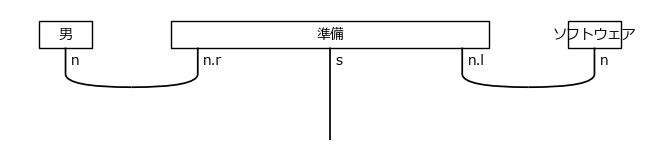

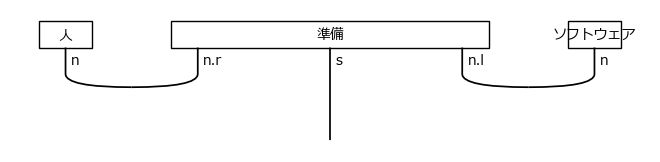

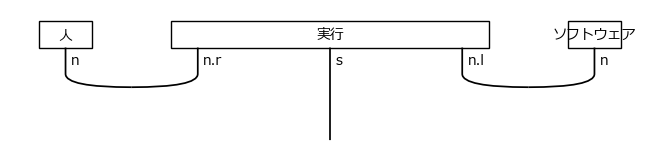

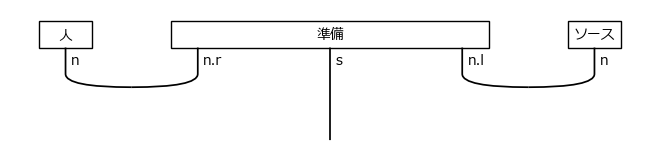

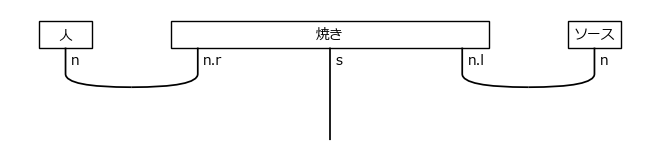

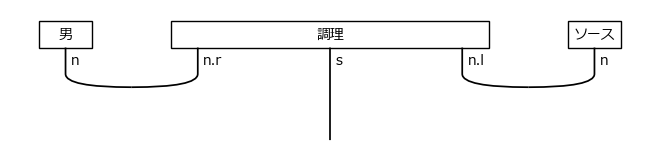

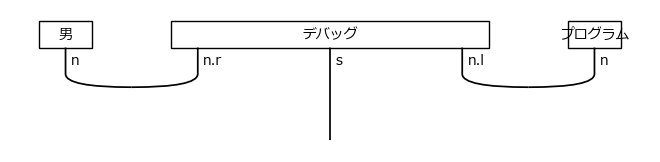

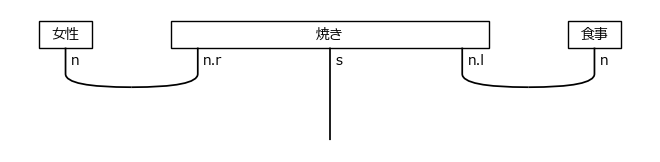

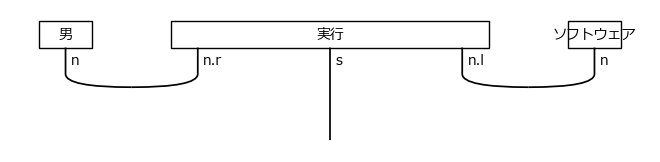

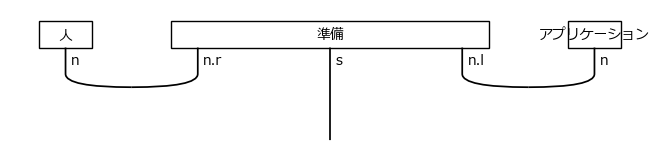

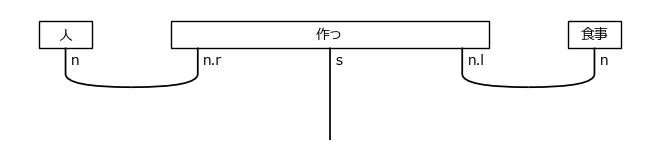

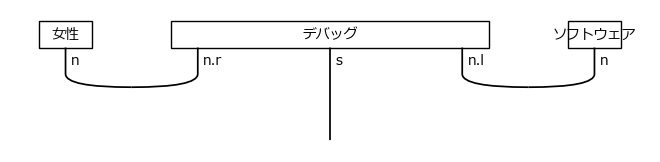

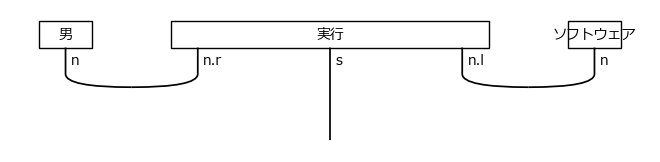

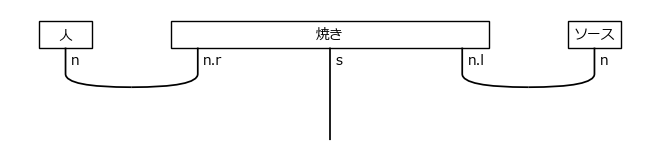

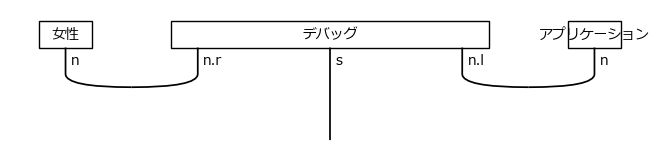

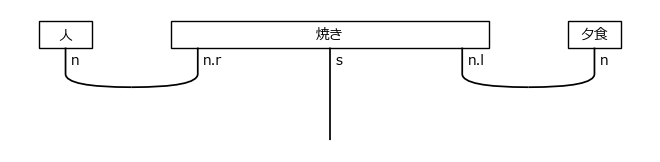

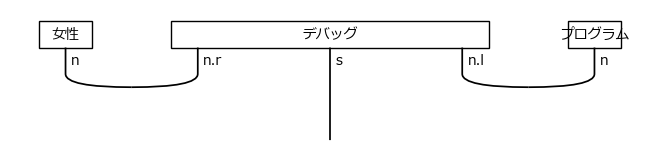

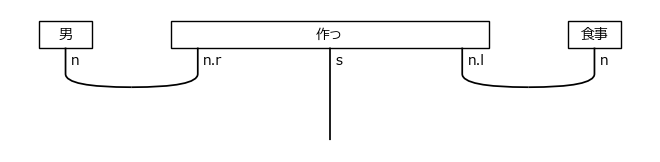

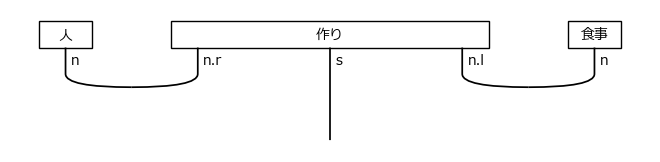

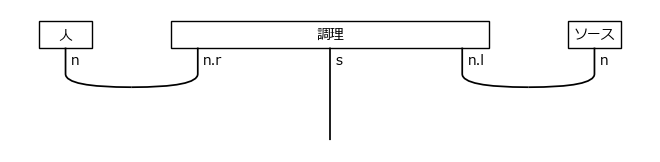

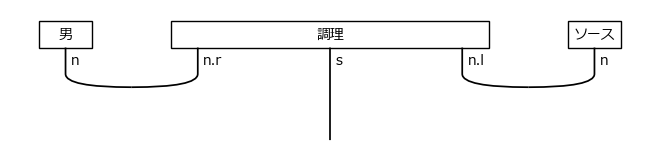

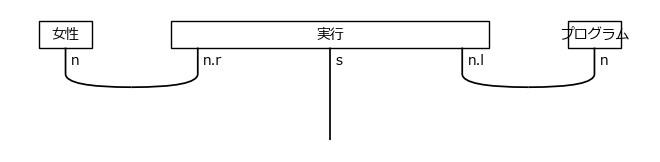

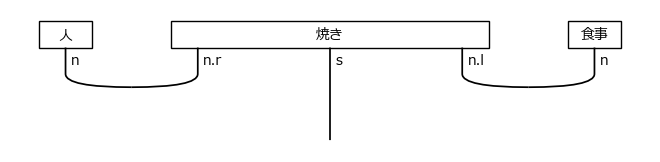

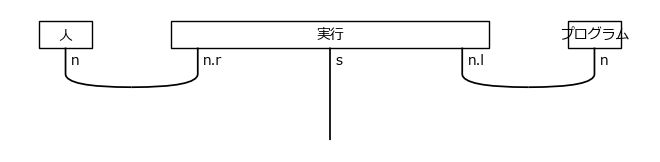

In [10]:
train_rot_diagrams = []
dev_rot_diagrams = []
test_rot_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    train_rot_diagrams.append(create_rotated_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    dev_rot_diagrams.append(create_rotated_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    target_word = [token.text for token in nlp(sentence) if token.dep_ == 'ROOT'][0]
    test_rot_diagrams.append(create_rotated_diagram(sentence))

# check diagrams
for d in range(len(train_sentences)):
    draw(train_rot_diagrams[d])

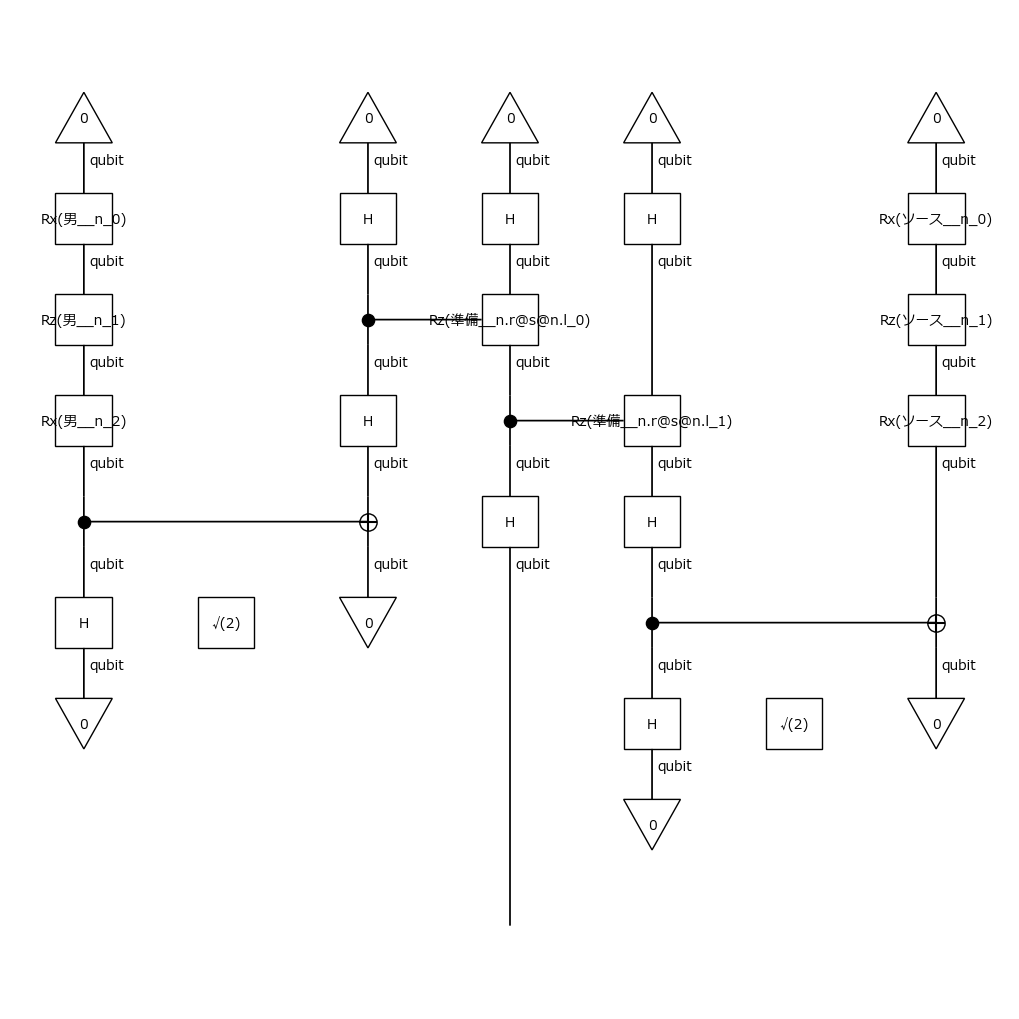

In [11]:
# 量子回路設計（IQPAnsatz）
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_rot_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_rot_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_rot_diagrams]

train_circuits[0].draw(figsize=(10, 10))

In [12]:
# 量子回路シミュレーションをする計算モデルを構築
all_circuits = train_circuits + dev_circuits + test_circuits # モデル初期化時に全量子回路を提供するための準備
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

# 損失関数と予測精度の定義
bce = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2
# roundで四捨五入して0or1に変換  # 正解数を総数で割る

In [13]:
# ハイパーパラメータ
BATCH_SIZE = 30
# LEARNING_RATE = 3e-2
EPOCHS = 400
SEED = 0

# trainerの定義
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.1, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=SEED
)

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [14]:
trainer.fit(train_dataset, val_dataset, log_interval=100)

Epoch 100:  train/loss: 0.1479   valid/loss: 0.1909   train/time: 28.29s   valid/time: 6.33s   train/acc: 1.0000   valid/acc: 0.9667
Epoch 200:  train/loss: 0.0821   valid/loss: 0.1030   train/time: 11.43s   valid/time: 3.29s   train/acc: 1.0000   valid/acc: 0.9667
Epoch 300:  train/loss: 0.0618   valid/loss: 0.0755   train/time: 11.73s   valid/time: 3.35s   train/acc: 1.0000   valid/acc: 0.9667
Epoch 400:  train/loss: 0.0440   valid/loss: 0.0648   train/time: 11.69s   valid/time: 3.24s   train/acc: 1.0000   valid/acc: 0.9667

Training completed!
train/time: 1m3s   train/time_per_epoch: 0.16s   train/time_per_step: 0.05s   valid/time: 16.22s   valid/time_per_eval: 0.04s


Train accuracy: 1.0
Test accuracy: 0.93333334


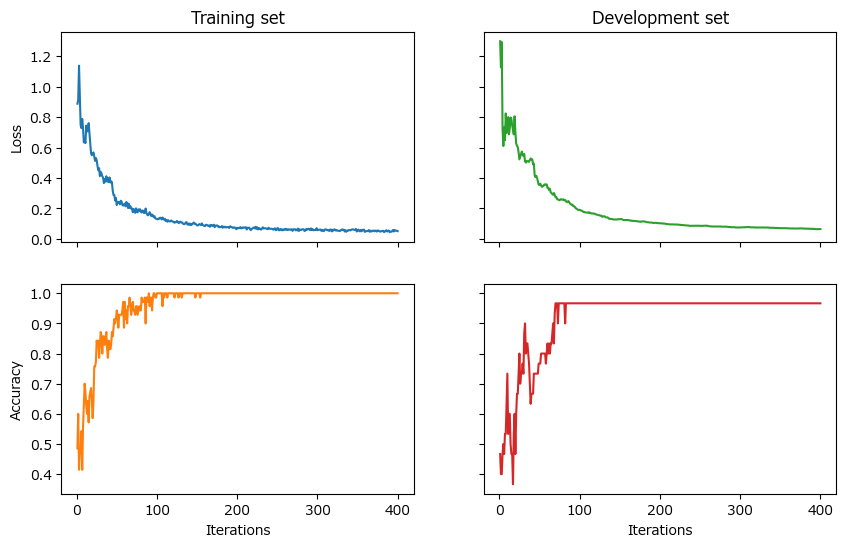

In [15]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

train_acc = acc(model(train_circuits), np.array(train_labels))
test_acc = acc(model(test_circuits), np.array(test_labels))
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)